# Leveraging Machine Learning for Sales Forecasting and Inventory Optimization

## 📚 Table of Contents
- [Introduction](#Introduction)
- [Data Preparation](#Data-Preparation)
- [EDA](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Model Training Testing and Tuning](#Model-Training-Testing-and-Tuning)
- [Inventory Optimization Strategy](#Inventory-Optimization-Strategy)
- [Conclusion](#Conclusion)

## Introduction

In the competitive retail landscape, accurately predicting future sales and efficiently managing inventory are vital for success. This project showcases an end-to-end solution for forecasting sales using machine learning and Python, and demonstrates the development of an inventory management strategy based on these forecasts. The objective is to minimize stockouts and overstock situations, leading to improved customer satisfaction and reduced operational costs.

## Data preparation

The sales data, consisting of two sheets from an Excel file, includes Store8Number, Itemnumber, sales quantity, and other relevant features. We concatenate the two sheets into a single DataFrame, preprocess the data by converting relevant columns to appropriate data types, and handle missing values.

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import plotly.graph_objs as go
import plotly.offline as pyo
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import math
from scipy.stats import norm

In [2]:
# Load the data (replace with the actual file path or URL)
data = pd.read_excel("./data/reach_data.xlsx", sheet_name='sale', dtype={
    'Date': str,
    'Store8Number': str,
    'Item Name': str,
    'Itemnumber': str,
    'Salesamount': str,
    'Salequantity': str,
    'Sales weight': str,
    'Unit of sale': str,
    'Total promotion based date store and items': str,
    'Promotionflag': str
})

data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [6]:
# Step 2: Data preprocessing
# Convert date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y.%m.%d')

# Convert numeric columns to appropriate data types
data['Salesamount'] = pd.to_numeric(data['Salesamount'], errors='coerce')
data['Salequantity'] = pd.to_numeric(data['Salequantity'], errors='coerce')
#data['Sale weight'] = pd.to_numeric(data['Sale weight'], errors='coerce')
data['Totalpromotionbaseddatestoreanditems'] = pd.to_numeric(data['Totalpromotionbaseddatestoreanditems'], errors='coerce')
data['Promotionflag'] = pd.to_numeric(data['Promotionflag'], errors='coerce')

# Handle missing values (using interpolation, mean, median, or dropping rows, depending on the context)
data.interpolate(method='pad',inplace=True)  # Interpolate missing values
data.dropna(inplace=True)  # Drop remaining rows with missing values

# Dropping negative rows 
data = data.drop(index=data[data['Salequantity']<0].index).reset_index(drop=True)

# Check for missing values and fill them with the median of the column
data.fillna(data.median(), inplace=True)

# Check for infinite or NaN values and replace them with the mean of the column
for col in data.columns:8
    if data[col].dtype != 'object' and data[col].dtype != '<M8[ns]':
        col_mean = data[col].mean()
        data[col] = data[col].apply(lambda x: col_mean if np.isnan(x) or np.isinf(x) else x)

# Check for outliers and remove them if necessary
data = data[(data['Salequantity'] < data['Salequantity'].quantile(0.99)) &
            (data['Salequantity'] > data['Salequantity'].quantile(0.01))]

Date
StoreNumber
Itemnumber
Itemname
Salesamount


C:\Users\ronal\AppData\Local\Temp\ipykernel_22456\2429163087.py:20: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

C:\Users\ronal\AppData\Local\Temp\ipykernel_22456\2429163087.py:20: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



Salequantity
Unitofsale
Totalpromotionbaseddatestoreanditems
Promotionflag


## EDA

We then conduct an EDA step by printing the first few rows of the DataFrame to get a sense of the data's structure and format. We also create a simple plot of monthly sales to visualize any trends or patterns in the data.

,Date,StoreNumber,Itemnumber,Itemname,Salesamount,Salequantity,Unitofsale,Totalpromotionbaseddatestoreanditems,Promotionflag
0,2018-10-30,3349,33288729,PATATES TAZE DÖKME KG,125.71,36.430,KG,235.42,0
1,2018-03-31,3853,91273613,ELMA PINK LADY KG,9.55,2.395,KG,478.16,0
2,2017-08-13,607,20280029,PATATES TAZE MİNİ KG.,43.65,8.819,KG,4903.35,0
3,2017-09-21,607,60270013,ELMA GALA KG,123.09,41.171,KG,445.73,0
4,2018-04-04,607,91273613,ELMA PINK LADY KG,88.42,22.158,KG,607.46,0


,StoreNumber,Itemnumber,Salesamount,Salequantity,Totalpromotionbaseddatestoreanditems,Promotionflag
count,21596.000000,2.159600e+04,21596.000000,21596.000000,21596.000000,21596.000000
mean,2340.182626,3.037228e+07,91.775198,22.333678,1498.032137,0.058946
std,1506.018226,2.355306e+07,139.337792,38.583078,2409.087091,0.235529
min,607.000000,2.703130e+05,0.810000,0.305000,0.000000,0.000000
25%,607.000000,1.027035e+07,19.570000,3.580000,192.650000,0.000000
50%,3349.000000,3.328803e+07,46.670000,9.257500,625.480000,0.000000
75%,3853.000000,4.527121e+07,104.692500,23.061250,1632.752500,0.000000
max,3853.000000,9.227441e+07,2380.000000,296.000000,18958.330000,1.000000


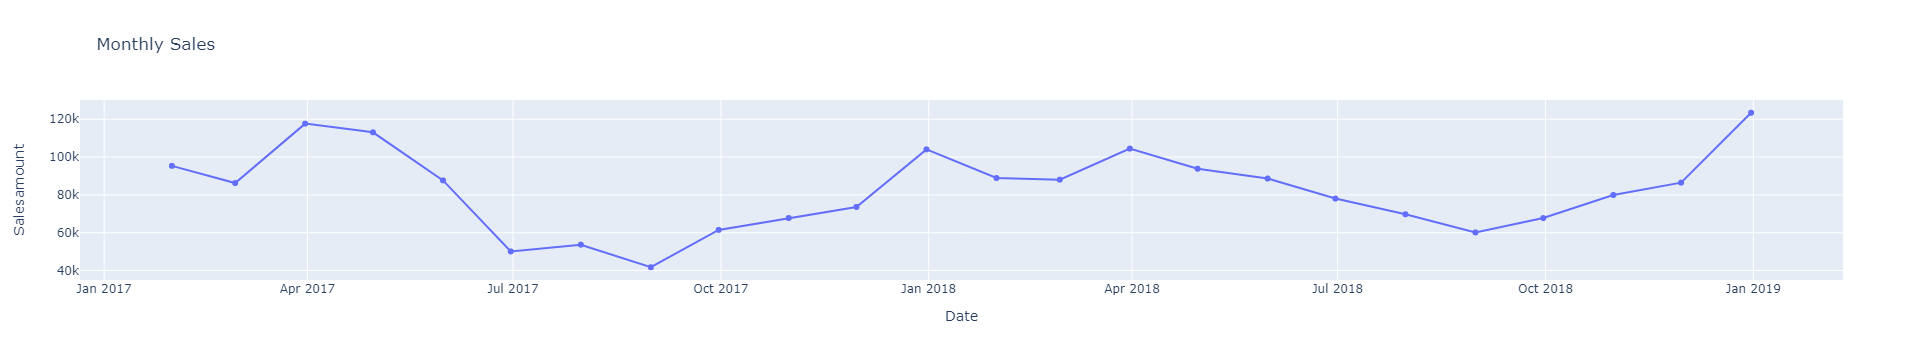

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.head())
    display(data.describe())

# Plot sales by date
data['Date'] = pd.to_datetime(data['Date'])
monthly_sales = data.groupby(pd.Grouper(key='Date', freq='M'))['Salesamount'].sum().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_sales['Date'], y=monthly_sales['Salesamount'], mode='lines+markers'))
fig.update_layout(title='Monthly Sales', xaxis_title='Date', yaxis_title='Salesamount')
pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)

## Feature Engineering

Next, we perform feature engineering to create new features that can potentially improve the performance of our machine learning models. We extract temporal information like the day of the week, month, and year from the date column. Additionally, we create lag features, representing past sales quantities, and rolling window features to calculate the mean and standard deviation of sales over a specific window.

In [8]:
# Step 3: Feature engineering (modified)

# Extract temporal features from the Date column
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday

# Create a feature for holidays or special events
holidays_dates = [
    '2017-01-01', '2017-12-25', '2017-11-23', '2017-07-04', '2017-12-31', '2017-05-29', '2017-09-04', '2017-02-20', '2017-10-09', '2017-11-11', '2017-01-16', 
    '2018-01-01', '2018-12-25', '2018-11-22', '2018-07-04', '2018-12-31', '2018-05-28', '2018-09-03', '2018-02-19', '2018-10-08', '2018-11-11', '2018-01-15'
]

# Convert the holiday dates to datetime objects
holidays_dates = pd.to_datetime(holidays_dates)

data['is_holiday'] = data['Date'].isin(holidays_dates).astype(int)

# Create a feature to capture day of the month (e.g., beginning, middle, or end)
data['day_of_month'] = data['Date'].apply(lambda x: 1 if 1 <= x.day <= 10 else 2 if 11 <= x.day <= 20 else 3)

# Create a feature to capture week of the year
data['week_of_year'] = data['Date'].dt.weekofyear

# Create a feature to capture sales lag (e.g., sales quantity for the same item at the same store 7 days ago)
data['sales_lag_7'] = data.groupby(['StoreNumber', 'Itemnumber'])['Salequantity'].shift(7)

# Create a feature to capture the rolling mean of sales quantity (e.g., 7-day moving average)
rolling_mean_7 = data.groupby(['StoreNumber', 'Itemnumber'])['Salequantity'].rolling(window=7).mean().reset_index(level=0, drop=True)
data['rolling_mean_7'] = rolling_mean_7.values

# Create a feature to capture the rolling standard deviation of sales quantity (e.g., 7-day moving standard deviation)
rolling_std_7 = data.groupby(['StoreNumber', 'Itemnumber'])['Salequantity'].rolling(window=7).std().reset_index(level=0, drop=True)
data['rolling_std_7'] = rolling_std_7.values

# One-hot encode categorical variables (e.g., Store8Number, Itemnumber)
data_encoded = pd.get_dummies(data, columns=['StoreNumber', 'Itemnumber', 'Unitofsale'])

# Fill missing values created by the lag and rolling window features with appropriate methods (e.g., forward fill, backward fill, or interpolation)
data_encoded.fillna(method='ffill', inplace=True)
data_encoded.fillna(method='bfill', inplace=True)


# Step 4: Train-test split
# Define the forecasting target variable (e.g., Sales quantity) and the features
target = 'Salequantity'
features = data_encoded.drop(columns=[target, 'Date', 'Itemname']).columns

# Split the data into training and testing sets based on time (e.g., 80% for training, 20% for testing)
train_size = int(len(data_encoded) * 0.8)
train_data = data_encoded.iloc[:train_size]
test_data = data_encoded.iloc[train_size:]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

C:\Users\ronal\AppData\Local\Temp\ipykernel_22456\970056616.py:24: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



## Model Training Testing and Tuning

For sales forecasting, we compare four different models: Linear Regression, Decision Tree Regressor, Random Forest Regressor, and LightGBM. Time series cross-validation is utilized to evaluate the models, with mean absolute percentage error (MAPE) as the performance metric. Hyperparameter tuning is performed using GridSearchCV, searching for the best combination of hyperparameters based on cross-validation results.

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_scorer():
    return make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Step 5: Hyperparameter tuning, model training, evaluation and selection
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [250, 500],
            'max_depth': [5, 10, 20]
        }
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, 20]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42),
        'params': {
            'n_estimators': [250, 500],
            'learning_rate': [0.1, 0.05],
            'num_leaves': [31, 50]
        }
    }
}

# Initialize a time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

best_model = None
best_mape = float('inf')

for model_name, model_info in models.items():
    print(f"Training, tuning and evaluating {model_name}")
    
    model = model_info['model']
    params = model_info['params']
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=tscv,
        scoring=mape_scorer(),
        n_jobs=-1
        ,error_score='raise'
    )

    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_mape_cv = -1 * grid_search.best_score_

    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best MAPE for {model_name}: {best_mape_cv}")

    if best_mape_cv < best_mape:
        best_mape = best_mape_cv
        best_model = grid_search.best_estimator_

print(f"Best model: {best_model.__class__.__name__}, with MAPE: {best_mape}")

# Step 6: Model predictions and evaluation on the test set
y_pred_test = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Test Set Mean Squared Error: {mse_test}, Test Set Mean Absolute Error: {mae_test}, Test Set Mean Absolute Percentage Error: {mape_test}")

# Save the model predictions to the test_data DataFrame
test_data['Predicted Sales quantity'] = y_pred_test

# Save the best model to a .pkl file
filename = 'best_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

Training, tuning and evaluating RandomForestRegressor
Best parameters for RandomForestRegressor: {'max_depth': 20, 'n_estimators': 500}
Best MAPE for RandomForestRegressor: 16.682618161128556
Training, tuning and evaluating LinearRegression
Best parameters for LinearRegression: {}
Best MAPE for LinearRegression: 107.49007143868076
Training, tuning and evaluating DecisionTreeRegressor
Best parameters for DecisionTreeRegressor: {'max_depth': 20}
Best MAPE for DecisionTreeRegressor: 20.045873584209566
Training, tuning and evaluating LightGBM
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 50}
Best MAPE for LightGBM: 19.34683202186423
Best model: RandomForestRegressor, with MAPE: 16.682618161128556
Test Set Mean Squared Error: 52.47182793508737, Test Set Mean Absolute Error: 2.7214063071037007, Test Set Mean Absolute Percentage Error: 14.322478271571093


C:\Users\ronal\AppData\Local\Temp\ipykernel_22456\4121833146.py:81: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Inventory Optimization Strategy
Upon obtaining the sales forecasts from the best-performing model, we develop an inventory management strategy, considering factors such as lead time, service level, and carrying costs. By calculating optimal order quantities (EOQ) and reorder points, the aim is to minimize stockouts and overstock situations.

The data is grouped by store and item, and the annual demand and standard deviation of demand are calculated for each group. Using these values, we compute the EOQ and reorder point for each store-item combination. The resulting inventory strategy is saved to a CSV file for further analysis or implementation in a retail management system.


In [13]:
# Step 7: Inventory optimization
# Read the two sheets into separate dataframes
df1 = pd.read_excel('./data/reach_data.xlsx', sheet_name='waste-inventory_2017', dtype={'Salequantity':'float'})
df2 = pd.read_excel('./data/reach_data.xlsx', sheet_name='waste-inventory_2018')

# Concatenate the two dataframes into one
data = pd.concat([df1, df2])

data = data.drop(index=data[data['Sale quantity']=='********  '].index)

data['Sale quantity'] = data['Sale quantity'].astype('float')
data['Date'] = pd.to_datetime(data['Date'])

# Constants (customize these based on your needs)
lead_time = 7  # Lead time in days
service_level = 0.95  # Desired service level (0.95 corresponds to 95%)
annual_ordering_cost = 100  # Ordering cost per order
annual_holding_cost_per_unit = 0.10  # Holding cost per unit per year

# Calculate the service level factor (Z) using the standard normal distribution
z = norm.ppf(service_level)

# Define a function to calculate the optimal order quantity (EOQ) and reorder point
def optimize_inventory(demand, std_demand, lead_time, annual_ordering_cost, annual_holding_cost_per_unit, z):
    # Calculate EOQ
    eoq = math.sqrt((2 * demand * annual_ordering_cost) / annual_holding_cost_per_unit)

    # Calculate lead time demand
    lead_time_demand = demand * (lead_time / 365)

    # Calculate the standard deviation of demand during the lead time
    std_lead_time_demand = std_demand * math.sqrt(lead_time)

    # Calculate safety stock
    safety_stock = z * std_lead_time_demand

    # Calculate the reorder point
    reorder_point = lead_time_demand + safety_stock

    return eoq, reorder_point

# Group the data by store and item
grouped_data = data.groupby(['Store Number', 'Item number'])

# Create a list to store the results
inventory_strategy_list = []

# Iterate through the grouped data and calculate the optimal order quantity (EOQ) and reorder point for each store-item combination
for (store, item), group in grouped_data:
    # Calculate the annual demand and standard deviation of demand
    annual_demand = group['Sale quantity'].sum()
    std_demand = group['Sale quantity'].std()

    # Calculate the optimal order quantity (EOQ) and reorder point
    eoq, reorder_point = optimize_inventory(annual_demand, std_demand, lead_time, annual_ordering_cost, annual_holding_cost_per_unit, z)

    # Create a DataFrame with the results
    result = pd.DataFrame({
        'Store Number': [store],
        'Item number': [item],
        'EOQ': [eoq],
        'Reorder Point': [reorder_point]
    })

    # Append the result DataFrame to the inventory_strategy_list
    inventory_strategy_list.append(result)

# Concatenate the DataFrames in the inventory_strategy_list to create the inventory_strategy DataFrame
inventory_strategy = pd.concat(inventory_strategy_list, ignore_index=True)

# Save the inventory_strategy DataFrame to a CSV file
inventory_strategy.to_csv('inventory_strategy.csv', index=False)


## Conclusion
This project demonstrates the effective application of machine learning techniques and Python to forecast sales and optimize inventory management in a retail context. By combining accurate sales forecasts with efficient inventory management strategies, businesses can achieve improved customer satisfaction and reduced operational costs. This project showcases the practical application of data science skills in a real-world business scenario and highlights the value of data-driven decision-making processes.